In [20]:
import paramiko
import pickle
import os
import pandas as pd
import zipfile
from datetime import datetime,timedelta
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy as np


def run_report(start,end):

    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)

    market_cap = pd.read_csv('input/market_cap.csv')

    firm_market_caps = []

    # Loop through the market cap data
    for i, date in enumerate(market_cap['Date']):
        for ticker in market_cap.columns[1:]:
            firm_date_market_cap = market_cap.at[i, ticker]
            firm_market_caps.append({'Date': date, 'Ticker': ticker, 'firm_date_market_cap': firm_date_market_cap})
    
    # Convert list to DataFrame
    firm_market_caps = pd.DataFrame(firm_market_caps)
    
    # Read the ray data
    ray_df = pd.read_excel('input/raycounty.xlsx')
    
    # Clean the columns and ticker values
    ray_df.columns = ray_df.columns.str.rstrip('\n')
    ray_df['Ticker'] = ray_df['Ticker'].str.split(' ', n=1, expand=True)[0].replace(' ', '')
    
    # Filter relevant columns and rows
    ray_df = ray_df[['Ticker', 'County']].head(100)
    
    # Merge the DataFrames
    report_df = pd.merge(firm_market_caps, ray_df, on='Ticker')
    
    # Convert 'Date' to datetime and sort the DataFrame
    report_df['Date'] = pd.to_datetime(report_df['Date'])
    report_df = report_df.sort_values('Date')
    
    
    # Group by Date and GICS Sector and sum the market caps
    report_df = report_df.groupby(['Date', 'County'])['firm_date_market_cap'].sum().reset_index()
    report_df.columns = ['Date','County','Market Cap']
    report_df = report_df[(report_df['Date'] >= start_date) & (report_df['Date'] <= end_date)]
    report_df['Return'] = report_df.groupby('County')['Market Cap'].transform(lambda x: ((x / x.iloc[0]) - 1) * 100)

    return(report_df)

In [21]:
test_report = run_report('2023-12-29','2024-05-31')
total_market_cap = test_report.groupby('Date')['Market Cap'].sum().to_frame().reset_index()
total_market_cap.columns = ['Date','Total Market Cap']
test_report = pd.merge(test_report,total_market_cap,on='Date')
print(f"Index Return: {test_report.iloc[-1]['Total Market Cap'] / test_report.iloc[0]['Total Market Cap']}")
test_report

Index Return: 1.0007891791352632


,Date,County,Market Cap,Return,Total Market Cap
0,2023-12-29,Allegheny,2.499627e+11,0.000000,9.545896e+11
1,2023-12-29,Berks,2.199858e+10,0.000000,9.545896e+11
2,2023-12-29,Bucks,1.758274e+10,0.000000,9.545896e+11
3,2023-12-29,Butler,1.274235e+10,0.000000,9.545896e+11
4,2023-12-29,Chester,1.037672e+11,0.000000,9.545896e+11
...,...,...,...,...,...
2115,2024-05-31,Philadelphia,2.178075e+11,-9.093845,9.553430e+11
2116,2024-05-31,Susquehanna,2.508892e+08,-20.334319,9.553430e+11
2117,2024-05-31,Warren,1.374319e+09,-12.259615,9.553430e+11
2118,2024-05-31,Washington,4.669735e+10,-6.333482,9.553430e+11


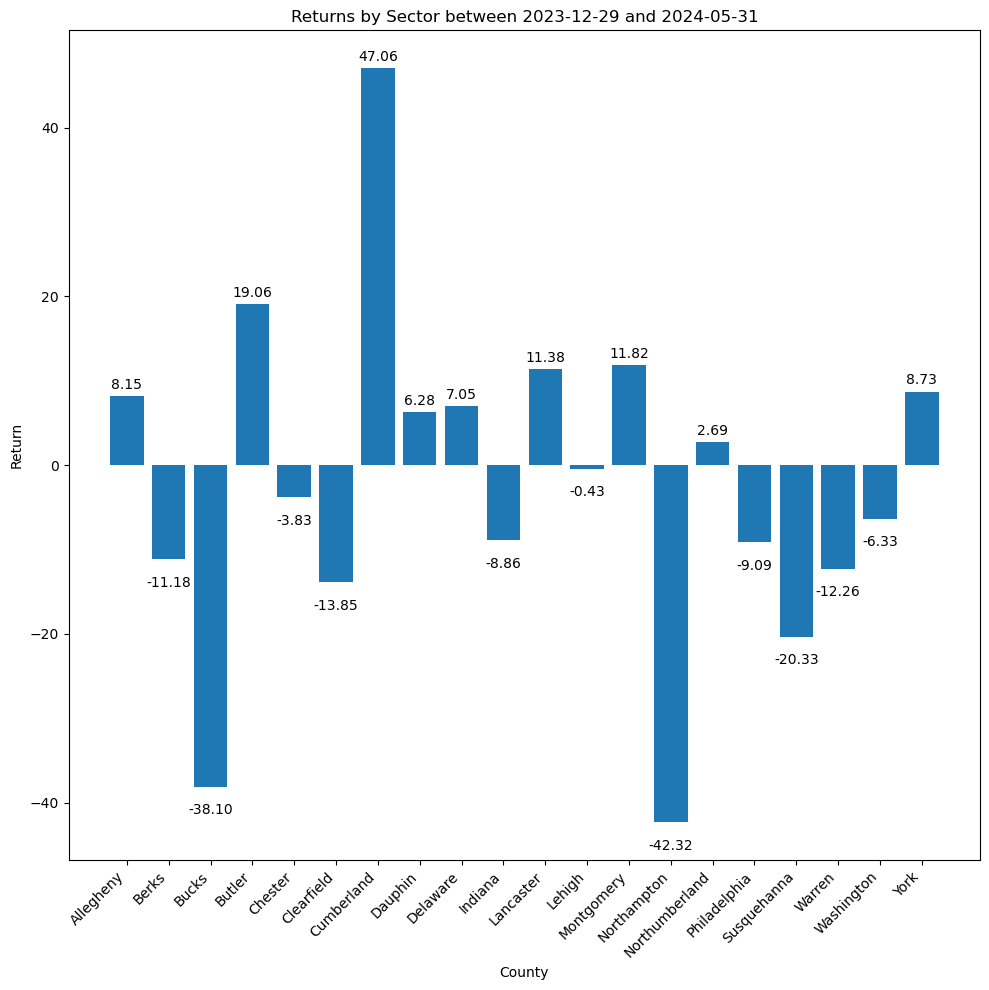

In [10]:
import matplotlib.pyplot as plt

last_day = test_report['Date'].max()
first_day = test_report['Date'].min()
last_day_data = test_report[test_report['Date'] == last_day]

plt.figure(figsize=(10, 10))
bars = plt.bar(last_day_data['County'], last_day_data['Return'])
plt.xlabel('County')
plt.ylabel('Return')
plt.title(f'Returns by Sector between {first_day.date()} and {last_day.date()}')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Annotate bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
    else:
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, -12),  # 12 points vertical offset
                     textcoords="offset points",
                     ha='center', va='top')

plt.show()


In [11]:
file_path = f'output/county_report_{first_day.date()}_{last_day.date()}.xlsx'
test_report.to_excel(file_path, index=False)